For ease of use, we advise to open this notebook in an Amazon SageMaker notebook instance and use the conda_pytorch_latest_p36 kernel, or in Amazon SageMaker Studio.

# Fine-tuning and deploying a HuggingFace summarization model on SageMaker with your own scripts and dataset

In this notebook, we will see how to fine-tune and deploy one of the [🤗 Transformers](https://github.com/huggingface/transformers) model for a summarization task on [Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/hugging-face.html) with your own scripts and data.

In the first part "Preparing the dataset" we show how to load your own dataset to s3 into separated files for training, validation and testing. We will use the [Women's E-Commerce Clothing Reviews dataset](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/) which contains e-commerce clothing reviews and review titles, but we also provide code to do it for your own custom dataset. In our case the text and summary columns are called `review_text` and `title` respectively, and the data is saved in s3 under the prefix `DEMO-sagemaker-huggingface-summarization`.

Afterwards, we walk you through how to create your own train and inference scripts to fine-tune and deploy a HuggingFace model on Amazon SageMaker.

Make sure that the latest version of SageMaker SDK is installed

In [ ]:
# Install the required libraries
!pip install datasets
!pip install py7zr
!pip install sagemaker –U

## Part 1: Preparing the dataset

One way to prepare your dataset for training on Amazon SageMaker is to have your training, validation and test datasets saved separately. This enables to effectively decouple data preparation from training in an architecture and for example ensure that the same datasets can be reused by different models with the same split. In this example we download the [Women's E-Commerce Clothing Reviews dataset](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/) from [Kaggle](https://www.kaggle.com/) and prepare it for HuggingFace using the [datasets](https://github.com/huggingface/datasets) library. Any dataset containing text and something that could be considered a summary (eg titles) can work here.

### Create a Kaggle account and download the dataset

In case you do not have a Kaggle account, please first make sure to create one by [registering](https://www.kaggle.com/account/login?phase=startSignInTab&returnUrl=%2F) to be able to download the dataset.

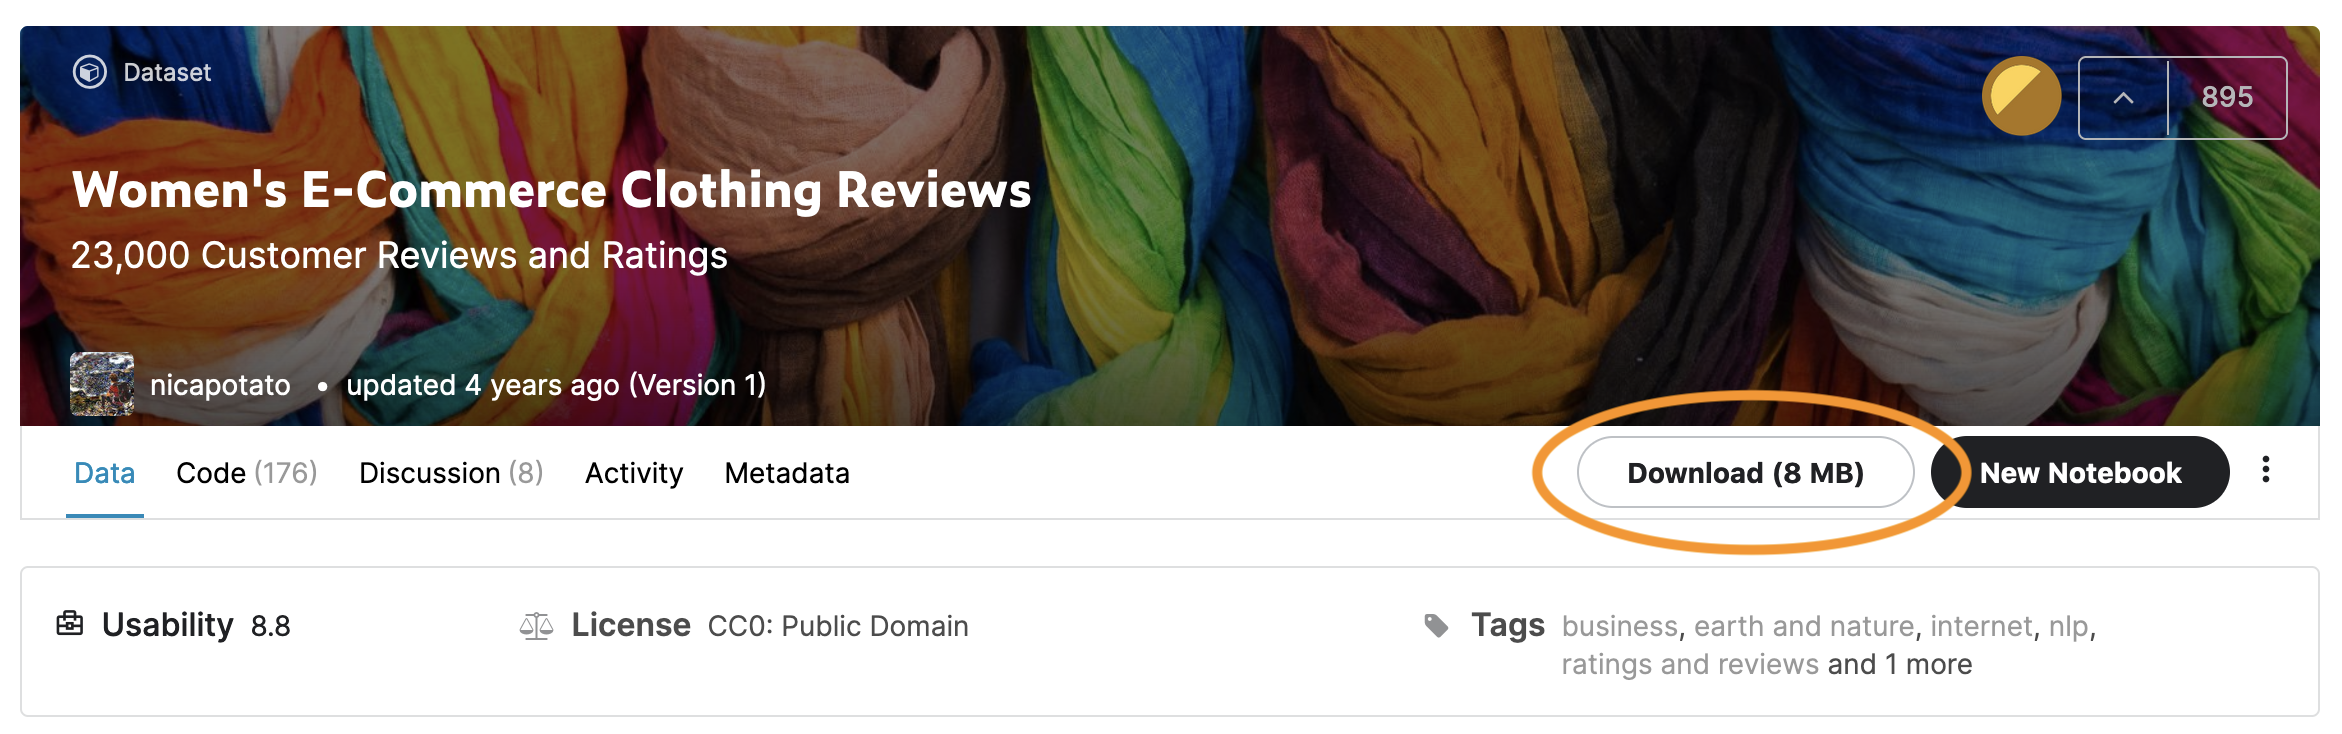

In [1]:
from IPython.display import Image
Image(filename='kaggle-download.png') 

Once you are registered, or if you already have an account, go then to  [Women's E-Commerce Clothing Reviews dataset](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/) and click on the download button. This will download an `archive.zip` to your computer locally. Unzip that file to get a csv file called `Womens Clothing E-Commerce Reviews.csv`. Upload this csv file in the same folder where you are running this notebook.

### Prepare the dataset for HuggingFace

We first import required packages and define the prefix where to save the data:

In [2]:
import os
import json
import io, boto3, sagemaker
import pandas as pd

from datasets import load_dataset, filesystems, DatasetDict


s3_resource = boto3.resource("s3")
session = sagemaker.Session()
session_bucket = session.default_bucket()

s3_prefix = "DEMO-sagemaker-huggingface-summarization"

We will first rename the columns to be lowercase and replace spaces by underscores

In [3]:
path_to_your_file = 'Womens Clothing E-Commerce Reviews.csv'

In [4]:
df = pd.read_csv(path_to_your_file)
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')
df = df.dropna(subset=['title','review_text'])
df.to_csv(path_to_your_file, index = False)

Now that we overwrote the file with cleaned column names, we prepare it for HuggingFace

In [5]:
# When using your own custom dataset (single CSV/JSON), you can use the datasets.Dataset.train_test_split() method  to shuffle and split your data.
# The splits will be shuffled by default. You can deactivate this behavior by setting shuffle=False

# Replace type to 'csv' if you are using a single CSV file, the rest of the steps are exactly the same
data = load_dataset('csv', data_files=path_to_your_file, split ='train') # path to your file

# # For single JSON file
# data = load_dataset('json', data_files=path_to_your_file, split ='train')

# Split into 70% train, 30% test + validation
train_test_validation = data.train_test_split(test_size=0.3)

# Split 30% test + validation into half test, half validation
test_validation = train_test_validation['test'].train_test_split(test_size=0.5)

# Gather the splits  to have a single DatasetDict

dataset = DatasetDict({
    'train': train_test_validation['train'],
    'validation': test_validation['train'],
    'test': test_validation['test'],})

Using custom data configuration default-7cff9e3258f5018d


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/csv/default-7cff9e3258f5018d/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['unnamed:_0', 'clothing_id', 'age', 'title', 'review_text', 'rating', 'recommended_ind', 'positive_feedback_count', 'division_name', 'department_name', 'class_name'],
        num_rows: 13772
    })
    validation: Dataset({
        features: ['unnamed:_0', 'clothing_id', 'age', 'title', 'review_text', 'rating', 'recommended_ind', 'positive_feedback_count', 'division_name', 'department_name', 'class_name'],
        num_rows: 2951
    })
    test: Dataset({
        features: ['unnamed:_0', 'clothing_id', 'age', 'title', 'review_text', 'rating', 'recommended_ind', 'positive_feedback_count', 'division_name', 'department_name', 'class_name'],
        num_rows: 2952
    })
})

In [7]:
print("Review Text\n{text}".format(text=dataset["train"]["review_text"][12]))
print("\nTitle\n{summary}".format(summary=dataset["train"]["title"][12]))
print("\nRating\n{rating}".format(rating=dataset["train"]["rating"][12]))

Review Text
On my screen this looked like burnt oranges were mixed with pink but this was all pink & very washed put pinks - looked awful on me as brunette. maybe will work for someone who likes pastels. overall style was also disappointing- just hung. this went back.

Title
Very pink

Rating
2


Finally, we write the training, validation and test dataframes to separate CSVs and upload them to S3.

Use the `save_to_disk` method to directly save your dataset to S3 in Hugging Face dataset format. The format is backed by the Apache Arrow format which enables processing of large datasets with zero-copy reads without any memory constraints for optimal speed and efficiency. You can use the `load_to_disk` method in your train script to directly load the dataset in the format it was saved.

In [8]:
s3 = filesystems.S3FileSystem()
dataset.save_to_disk(f"s3://{session_bucket}/{s3_prefix}/train/", fs=s3)

## Part 2: Fine-tune and deploy a HuggingFace model on Amazon SageMaker

Now that the data is ready and saved in s3, we will demonstrate how to fine-tune and deploy a HuggingFace model on Amazon SageMaker with your own scripts.

In [9]:
text_column = "review_text"
target_column = "title"

This notebook is built to run with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a sequence-to-sequence version in the Transformers library. Here we picked the [`pegasus-xsum`](https://huggingface.co/google/pegasus-xsum) checkpoint. 

In [10]:
model_name = "google/pegasus-xsum"

### Write the training script

To fine-tune a HuggingFace model with a custom dataset on Amazon SageMaker, we will write a training script to be used by the Amazon SageMaker Training Job.

The training script will need to do the following steps:
- Load a pretrained Tokenizer and Model
- Load and Tokenize datasets
- Define the Training Arguments
- Define a Trainer
- Train the model and save the checkpoint with the best performance on the validation set
- Evaluate the best checkpoint on the test set

These steps will be done in a `train()` function which uses a couple helper functions:
`tokenize()` takes a batch, specified text and target columns, and tokenizes them with the Tokenizer loaded in memory,
`load_and_tokenize()` which reads data from s3 and applies the `tokenize()` function, and `compute_metrics()` to compute ROUGE scores for evaluation.

The script uses AutoTokenizer and AutoModelForSeq2SeqLM which works with any [🤗 Transformers](https://github.com/huggingface/transformers) model for summarization. You might however want to change some hyperparameters depending on what works best for each model. Here we used adafactor as optimizer for Pegasus for example.

All computations will be running inside Amazon SageMaker HuggingFace training and inference containers, which we call using the [SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/index.html)

In [11]:
!pygmentize source/train.py

# This is the script that will be used in the training container
import argparse
import logging
import os
import sys

import numpy as np
import nltk

nltk.download("punkt")
from nltk import sent_tokenize

from datasets import load_metric, load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments


logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))


def tokenize(batch, text_column, target_column, max_source, max_target):
    tokenized_input = tokenizer(
        batch[text_column], padding="max_length", truncation=True, max_length=max_source
    )
    tokenized_target = tokenizer(
        batch[target_column],
        padding="max_length",
        truncation=True,
        max_length=max_target,
    )

    tokenized_input["labels"] = tokenized_target["input_ids"]

    return tokenized_input


def load_and_tokenize_dataset(data_dir, spli

By default, the `Trainer` saves several checkpoints before selecting the best one. Once the best checkpoint is loaded in memory and saved, those remaining checkpoints are not needed anymore. They can be safely deleted (which we do in the last line of the `train()`) to liberate space in the `SM_MODEL_DIR` which content will be used later for creating a SageMaker Model and deploy it to an endpoint.

### Fine-tuning the model on SageMaker

We first load a couple of libraries and objects, namely `sagemaker` and the `HuggingFace` SageMaker Estimator which will be used to launch a training job.

In [12]:
import sagemaker

session = sagemaker.Session()
session_bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [13]:
from sagemaker.huggingface import HuggingFace

In [14]:
output_path = f"s3://{session_bucket}/{s3_prefix}"

We define a few arguments to be sent to the training script which will be read by the parser.

In [15]:
# We set the number of epochs to 1 to reduce the training time in this demo.
# For complete fine-tuning of the model please consider increasing the number of epochs to e.g. 5
hyperparameters = {
    "model-name": model_name,
    "text-column": text_column,
    "target-column": target_column,
    "epoch": 1,
}

Thanks to [🤗 Transformers'](https://github.com/huggingface/transformers) `Trainer` seamless integration with [SageMaker Distributed Data Parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html), we can make use of instances with several GPU units to parallelize and speed up training, without any modification to our training script.

When defining the SageMaker HuggingFace Estimator we specify a training script and source directory (here only containing `train.py`, but it could contain any additional modules and a `requirements.txt`), as well as the instance type on which to run the Training Job.

In [16]:
# configuration for running training on smdistributed Data Parallel
# Estimated runtime: 1.5h for 1 epoch
distribution = {"smdistributed": {"dataparallel": {"enabled": True}}}
huggingface_estimator = HuggingFace(
    entry_point="train.py",
    source_dir="source",
    base_job_name="huggingface-summarizer",
    instance_type="ml.p3.16xlarge",
    instance_count=1,
    volume_size=200,
    transformers_version="4.6.1",
    pytorch_version="1.7.1",
    py_version="py36",
    output_path=output_path,
    role=role,
    hyperparameters=hyperparameters,
    distribution=distribution,
)

We then launch the training job by specifying where to read the data from.
'train' will be loaded inside `SM_CHANNEL_TRAIN`, 'validation' inside `SM_CHANNEL_VALIDATION` and 'test' inside `SM_CHANNEL_TEST`, which will be the data directories inside the container running `train.py`.

In [ ]:
huggingface_estimator.fit({"train": f"s3://{session_bucket}/{s3_prefix}/train/"})

With distributed training on a p3.16xlarge instance, the training should take around 6 hours for 5 epochs.

### Bring your own inference script

Our friends at HuggingFace have made inference on SageMaker for transformers model simpler than ever thanks to the [SageMaker HuggingFace Inference Toolkit](https://github.com/aws/sagemaker-huggingface-inference-toolkit). You can directly deploy the previously trained model by simply setting up the environment variable "HF_TASK":"summarization" following the instructions on the [HuggingFace website](https://huggingface.co/google/pegasus-xsum) selecting "Deploy" and then "Amazon SageMaker", without the need to write an inference script.

However, when needing specific post-processing, for example if for a same input you want to return several summaries based on different text generation parameters, bringing your own `inference.py` script might be useful, and relatively straightforward:

In [37]:
!pygmentize source/inference.py

# This is the script that will be used in the inference container
import json
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def model_fn(model_dir):
    """
    Load the model and tokenizer for inference
    """
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir).to(device).eval()

    return {"model": model, "tokenizer": tokenizer}


def predict_fn(input_data, model_dict):
    """
    Make a prediction with the model
    """
    text = input_data.pop("inputs")
    parameters_list = input_data.pop("parameters_list", None)

    tokenizer = model_dict["tokenizer"]
    model = model_dict["model"]

    # Parameters may or may not be passed
    input_ids = tokenizer(
        text, truncation=True, padding="longest", return_tensors="pt"
    ).input_ids.to(device)

    if parameters_list:
        predictions = []
        for pa

As we can see, the only requirements to writing such an inference script for HuggingFace on SageMaker is that the inference script shall contain the following template functions:
- `model_fn()` reading the content of what was saved at the end of the training job inside `SM_MODEL_DIR`, or from an existing model weights directory saved as a tar.gz in s3. We will use it to load the trained Model and associated Tokenizer
- `input_fn()` used here simply to format the data receives from a request made to the endpoint.
- `predict_fn()` calling the output of `model_fn()` (so here the model and tokenizer) to run inference on the output of `input_fn()`.

Optionally an `output_fn()` can be created for inference formatting, using the output of `predict_fn()`, but we did not use it here.


### Create and deploy a SageMaker Model to an endpoint and test it

This time we will import the SageMaker `HuggingFaceModel` object which will help us create a SageMaker Model and deploy it to an endpoint.

In [18]:
from sagemaker.huggingface import HuggingFaceModel

Again, we specify here the inference script that we wrote earlier, a source directory (here again containing only `inference.py` but could contain modules and a `requirements.txt`) and `model_data` specifying where to load the model weights from. Using `huggingface_estimator.model_data` directly points to the s3 location where the output of the `huggingface_estimator` (after training) was saved, but any s3 arn containing pre-trained weights compressed as a `tar.gz` could work.

In [19]:
model_name = "summarization-model"

model_for_deployment = HuggingFaceModel(
    entry_point="inference.py",
    source_dir="source",
    model_data=huggingface_estimator.model_data,
    role=role,
    pytorch_version="1.7.1",
    py_version="py36",
    transformers_version="4.6.1",
    name=model_name,
)

Finally, we deploy the register model by specifying the instance type.

In [20]:
endpoint_name = "summarization-endpoint"

predictor = model_for_deployment.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    endpoint_name=endpoint_name,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

--------!

Once the model is deployed, you can test it directly:

In [29]:
print("Review Text\n{text}".format(text=dataset["test"]["review_text"][13]))
print("\nTitle\n{summary}".format(summary=dataset["test"]["title"][13]))
print("\nRating\n{rating}".format(rating=dataset["test"]["rating"][13]))

Review Text
Such an easy to wear and nicely cut summer dress. it does not wrinkle, has pretty colors and fits very well. i haven't washed it yet, but i like the idea that it can be machine washed. highly recommend. the fabric is good quality, a little bit thick for hot days though.

Title
Wonderful summer dress

Rating
5


In [35]:
# Examples taken from the test set
texts = [
    dataset["test"]["review_text"][13]
]

inputs = {
    "inputs": texts,
    "parameters_list": [
        {"length_penalty": 2, "num_beams": 5, "do_sample": True},
        {"length_penalty": 1, "num_beams": 5, "do_sample": True},
        {"length_penalty": 0.6, "num_beams": 3, "do_sample": True},
        {"max_length": 25, "top_p": 0.92, "top_k": 50, "do_sample": True},
    ],
}

In [36]:
summary = predictor.predict(inputs)
print(summary)

[['Beautiful dress.'], ['Great summer dress.'], ['Simple, cute dress'], ['Great dress']]


Lastly, please remember to delete the Amazon SageMaker endpoint to avoid charges.

In [ ]:
predictor.delete_endpoint()

## Conclusion

In this notebook, we trained and deployed a HuggingFace model for Text Summarization with custom scripts and data on Amazon SageMaker. You can use this solution to train and deploy other [pretrained models](https://huggingface.co/models) provided by HuggingFace. [Sample notebooks](https://github.com/huggingface/notebooks/tree/master/sagemaker) are available on GitHub.